<a href="https://colab.research.google.com/github/yeon524/TEAM_PROJECT/blob/main/TA_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/yeon524/kpop-lyrics-analytics.git
!ls kpop-lyrics-analytics

Cloning into 'kpop-lyrics-analytics'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 196 (delta 3), reused 9 (delta 3), pack-reused 185 (from 1)
Receiving objects: 100% (196/196), 41.17 MiB | 23.06 MiB/s, done.
Resolving deltas: 100% (71/71), done.
analytics_kiwi.ipynb	       clustering.ipynb  lda.html    requirements.txt
analytics_konlpy.ipynb	       datasets		 lyrics.d2v
analytics_repeatability.ipynb  docs		 README.md


In [2]:
!ls kpop-lyrics-analytics/datasets


language_ratio_per_year.csv   lyrics_word_count_kiwi.csv
lyrics_by_year_1964_2023.csv  lyrics_word_count_konlpy.csv


In [3]:
import pandas as pd

# 1) CSV 불러오기
df = pd.read_csv("kpop-lyrics-analytics/datasets/lyrics_by_year_1964_2023.csv")

# 2) 연도 필터링 (1970~2019)
df = df[(df['year'] >= 1970) & (df['year'] <= 2019)].copy()

# 3) 가사 없는 데이터 제거
df = df.dropna(subset=['lyric'])

# 4) 최종 확인
df.head(), df.shape

(          id  year      title singer  \
 171  4058660  1970      소양강처녀    김태희   
 173  3773396  1970  가는 정 오는 정    남정희   
 175  3622569  1970  이정표 없는 거리    김상진   
 176  3621632  1970  아마도 빗물이겠지    이상열   
 177  3621631  1970        난이야    이상열   
 
                                                  lyric  x_rated  
 171  해 저문 소양강에 황혼이 지면\n외로운 갈대 밭이\n슬피 우는 두견새야\n열 여덣 ...    False  
 173  아롱진 옷자락에\n서글픈 사연 안고\n내 마음은 울면서도\n겉으로는 웃으며\n사랑도...    False  
 175  이리 가면 고향이오\n저리 가면 타향인데\n이정표 없는 거리\n헤매 도는 삼거리 길...    False  
 176  맺지 못할 사랑이기에\n말없이 헤어졌고\n돌아서는 두발 길에\n이슬비는 내리네\n사...    False  
 177  난이야 난이야\n사랑을 모두 주고\n울며 떠나간 너 바보구나\n때늦은 후회지만\n너...    False  ,
 (3914, 6))

In [4]:
# 필터링: 1970 ~ 2019
df = df[(df['year'] >= 1970) & (df['year'] <= 2019)].copy()

# 가사 없는 행 제거
df = df.dropna(subset=['lyric'])

In [5]:
# year → decade (예: 1973 → 1970, 1998 → 1990)
df['decade'] = (df['year'] // 10) * 10

df[['year', 'decade']].head()
df['decade'].value_counts().sort_index()

,count
decade,
1970,332
1980,677
1990,942
2000,998
2010,965


In [6]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

In [7]:
# 1) 가사 리스트 만들기
docs = df["lyric"].astype(str).tolist()

# 2) 한국어 멀티태스크 Sentence-BERT
embedding_model = SentenceTransformer("jhgan/ko-sroberta-multitask")

# 3) 문장 임베딩 계산 (조금 시간 걸릴 수 있음)
embeddings = embedding_model.encode(docs, show_progress_bar=True)

embeddings.shape   # (문서 수, 768) 이런 식으로 나올 거야


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/123 [00:00<?, ?it/s]

(3914, 768)

In [8]:
from sklearn.metrics import silhouette_score

K_list = [4, 5, 6, 7]
for k in K_list:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    print(f"k={k}, silhouette={score:.3f}")


k=4, silhouette=0.032
k=5, silhouette=0.031
k=6, silhouette=0.026
k=7, silhouette=0.022


In [9]:
best_k = 5  # 너가 고른 숫자로 바꿔

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

df["cluster"] = cluster_labels
df[["year", "decade", "title", "cluster"]].head()


,year,decade,title,cluster
171,1970,1970,소양강처녀,3
173,1970,1970,가는 정 오는 정,1
175,1970,1970,이정표 없는 거리,2
176,1970,1970,아마도 빗물이겠지,3
177,1970,1970,난이야,1


In [14]:
!pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 MB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 11.4 MB/s eta 0:00:00
  Created wheel for kiwipiepy_model: filename=kiwipiepy_model-0.22.0-py3-none-any.whl size=79625203 sha256=b462ddb9d579d848a6d8294fcbca72e522b085581d47c15eb4d655f1a4332578
  Stored in directory: /root/.cache/pip/wheels/e5/4b/3f/aa850a40d0f9709fd4c6d37d48402ca95354264236e1205ea3
Successfully built kiwipiepy_model


In [15]:
from kiwipiepy import Kiwi
kiwi = Kiwi()

def tokenize(text):
    if not isinstance(text, str):
        return []
    return [token.form for token in kiwi.tokenize(text)
            if len(token.form) > 1]   # 한 글자 제거


In [17]:
from kiwipiepy import Kiwi
kiwi = Kiwi()

def tokenize(text):
    if not isinstance(text, str):
        return []
    return [token.form for token in kiwi.tokenize(text) if len(token.form) > 1]


In [18]:
df["tokens"] = df["lyric"].apply(tokenize)


In [19]:
from collections import Counter

cluster_keywords = {}

for c in sorted(df["cluster"].unique()):
    tokens_all = []
    for tokens in df[df["cluster"] == c]["tokens"]:
        tokens_all.extend(tokens)

    common = Counter(tokens_all).most_common(30)
    cluster_keywords[c] = common

    print(f"\n=== Cluster {c} 대표 단어 ===")
    print([(w, n) for w, n in common[:15]])



=== Cluster 0 대표 단어 ===
[('you', 1208), ('me', 996), ('it', 981), ('어도', 846), ('에게', 824), ('사랑', 702), ('the', 702), ('Oh', 690), ('oh', 651), ('우리', 637), ('이제', 602), ('모르', 597), ('my', 574), ('어요', 564), ('to', 531)]

=== Cluster 1 대표 단어 ===
[('사랑', 4939), ('그대', 2550), ('어도', 2119), ('어요', 1996), ('에게', 1875), ('이제', 1524), ('다시', 1506), ('어서', 1249), ('눈물', 1227), ('버리', 1139), ('우리', 1093), ('지만', 1091), ('떠나', 1087), ('모르', 957), ('아프', 947)]

=== Cluster 2 대표 단어 ===
[('우리', 667), ('사랑', 646), ('그대', 568), ('어요', 507), ('ᆯ라', 445), ('마음', 397), ('하늘', 379), ('어서', 358), ('처럼', 314), ('ᆫ다', 310), ('바람', 302), ('사람', 299), ('어도', 281), ('어라', 279), ('으로', 256)]

=== Cluster 3 대표 단어 ===
[('그대', 1756), ('사랑', 1752), ('어요', 918), ('어도', 731), ('마음', 723), ('눈물', 670), ('이제', 662), ('처럼', 650), ('우리', 643), ('떠나', 553), ('버리', 528), ('에게', 525), ('다시', 518), ('가슴', 486), ('바람', 479)]

=== Cluster 4 대표 단어 ===
[('사랑', 3371), ('그대', 1772), ('에게', 1541), ('어요', 1297), ('어도', 1178), ('

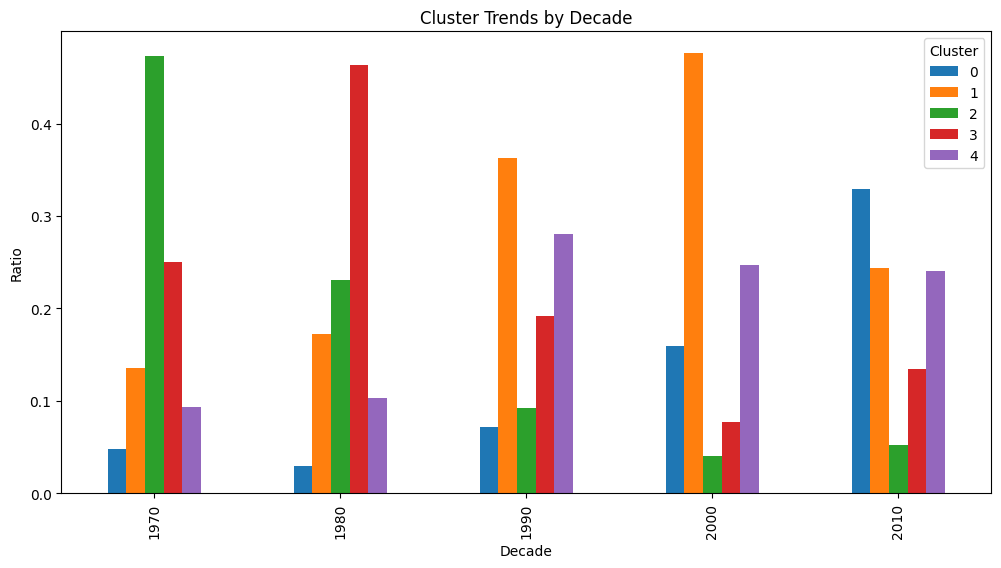

In [21]:
import matplotlib.pyplot as plt


cluster_decade = df.groupby(["decade", "cluster"]).size().unstack(fill_value=0)
cluster_ratio = cluster_decade.div(cluster_decade.sum(axis=1), axis=0)

cluster_ratio.plot(kind="bar", figsize=(12,6))
plt.title("Cluster Trends by Decade")
plt.xlabel("Decade")
plt.ylabel("Ratio")
plt.legend(title="Cluster")
plt.show()


In [25]:
cluster_names = {
    0: "English-Mixed Love Hooks",
    1: "Breakup & Tears",
    2: "We / Us & Love",
    3: "Intense Love & Regret",
    4: "Romantic Love & Memories"
}

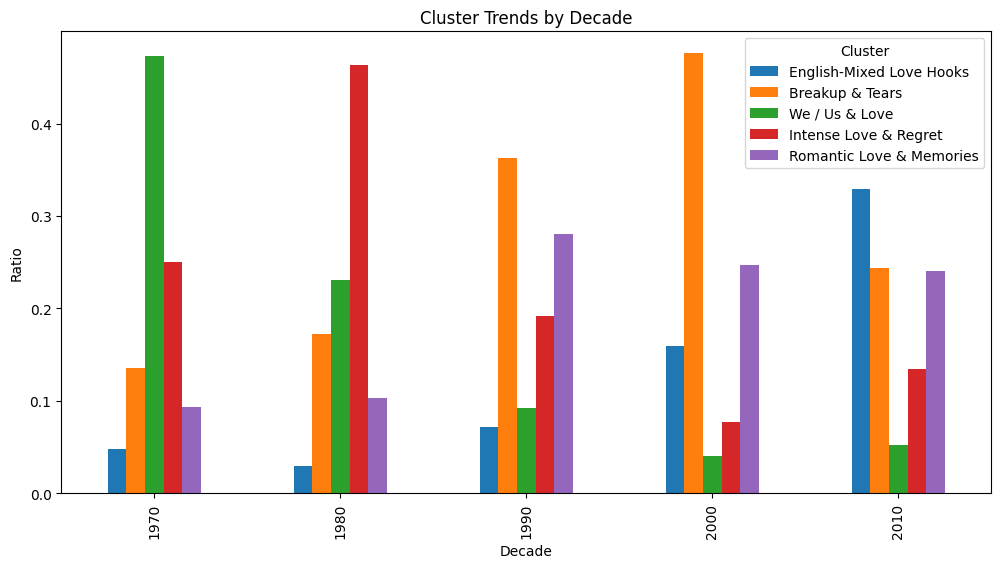

In [26]:
import matplotlib.pyplot as plt

# 기존처럼 비율 그래프 먼저 그리기
ax = cluster_ratio.plot(kind="bar", figsize=(12, 6))

plt.title("Cluster Trends by Decade")
plt.xlabel("Decade")
plt.ylabel("Ratio")

# 범례 라벨을 cluster_names로 교체
handles, labels = ax.get_legend_handles_labels()
new_labels = [cluster_names[int(label)] for label in labels]
ax.legend(handles, new_labels, title="Cluster")

plt.show()


In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def topic_model_for_cluster(c, n_topics=3):
    texts = df[df["cluster"] == c]["lyric"].tolist()

    # BOW vectorizer
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
    X = vectorizer.fit_transform(texts)

    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42
    )
    lda.fit(X)

    words = vectorizer.get_feature_names_out()

    print(f"\n=== Cluster {c} — Topic Modeling ===")
    for idx, comp in enumerate(lda.components_):
        top_words = [words[i] for i in comp.argsort()[-15:]]
        print(f"Topic {idx}: {top_words}")


In [30]:
for c in sorted(df["cluster"].unique()):
    topic_model_for_cluster(c, n_topics=3)



=== Cluster 0 — Topic Modeling ===
Topic 0: ['너무', 'yeah', '없어', 'eh', 'don', '나의', '나를', 'come', 'boy', 'love', '나는', 'oh', 'hey', 'baby', '내가']
Topic 1: ['너무', 'fly', 'know', 'let', '너의', '내게', 'heart', 'knock', 'yeah', 'love', 'hot', 'girl', 'baby', 'ah', 'la']
Topic 2: ['boy', 'bo', 'bad', '나를', 'don', '모두', 'yes', 'baby', 'boom', '내가', 'ring', 'yeah', 'like', 'uh', 'oh']

=== Cluster 1 — Topic Modeling ===
Topic 0: ['나의', '니가', '사랑을', '사람', '그렇게', 'bye', '다시', '이젠', '내게', '너의', '없어', '내가', 'love', '나를', '너를']
Topic 1: ['않아', '내게', '사랑해', '정말', '이젠', '나는', '너무', '제발', '너의', '나를', 'oh', '내가', '다시', '니가', '너를']
Topic 2: ['이렇게', '내게', '나는', '사랑', '이젠', '너를', '없는', '그대를', '너무', '그댈', '나의', '다시', '나를', '내가', '그대']

=== Cluster 2 — Topic Modeling ===
Topic 0: ['위해', '아름다운', 'life', 'love', '간다', 'ya', '우리', '없는', '그대', 'la', '너의', '나의', '나는', '내가', '함께']
Topic 1: ['tu', '걸어요', '거리를', '모두', '우리', '다시', '하늘', '마음', '정말', '나는', '둘이', '그대', '그대여', '우리는', '나의']
Topic 2: ['노래', '다시', '나의', '아

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def topic_model_for_cluster(c, n_topics=5):   # ← 3 → 5로 변경
    texts = df[df["cluster"] == c]["lyric"].tolist()

    # BOW vectorizer
    vectorizer = CountVectorizer(
        max_df=0.95,
        min_df=2,           # 너무 적으면 1로 낮춰도 됨
        stop_words="english"
    )
    X = vectorizer.fit_transform(texts)

    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42
    )
    lda.fit(X)

    words = vectorizer.get_feature_names_out()

    print(f"\n=== Cluster {c} - Topic Modeling ===")
    for idx, comp in enumerate(lda.components_):
        top_words = [words[i] for i in comp.argsort()[-15:]]
        print(f"Topic {idx}: {top_words}")

# 클러스터 0~4 전부에 대해 토픽 5개씩 출력
for c in sorted(df["cluster"].unique()):
    topic_model_for_cluster(c, n_topics=5)



=== Cluster 0 - Topic Modeling ===
Topic 0: ['니가', '없어', 'sexy', '나를', 'pop', 'don', '나의', 'hey', 'love', '나는', 'come', 'eh', 'boy', 'oh', '내가']
Topic 1: ['hot', '내가', 'baby', '아예', 'high', '아래', '내게', 'love', 'girl', 'yeah', 'fly', 'know', 'don', 'heart', 'la']
Topic 2: ['너의', '내가', '니가', '나를', '으르렁', 'change', 'boom', '모두', 'yes', 'don', 'bo', 'knock', 'ring', 'oh', 'uh']
Topic 3: ['없어', 'hey', 'just', 'ah', '너의', 'hot', '나를', 'like', 'let', 'girl', '내가', 'love', 'yeah', 'baby', 'oh']
Topic 4: ['멀리', '너무', 'blah', '없어', '모두', 'ah', '지금', 'huh', 'mr', '내가', '우리', '나는', 'hey', 'ooh', 'like']

=== Cluster 1 - Topic Modeling ===
Topic 0: ['그렇게', '사랑은', '사랑을', '나의', '니가', 'baby', '다시', '너의', 'lonely', '없어', '내가', '내게', '나를', 'love', '너를']
Topic 1: ['ooh', '그냥', '이렇게', '너의', '사랑해', '제발', '너무', 'oh', '않아', '나는', '내가', '다시', '너를', '나를', '니가']
Topic 2: ['없는', '사랑', '너무', '이젠', '그대가', '나는', '이렇게', '내게', '나의', '다시', '그대를', '내가', '나를', '그댈', '그대']
Topic 3: ['니가', '정말', '나도', '내게', '이젠', '몰라', '

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

def add_topics_for_cluster(df, cluster_id, n_topics=3):
    # 1) 해당 클러스터만 추출
    sub = df[df["cluster"] == cluster_id].copy()
    texts = sub["lyric"].astype(str).tolist()

    # 2) BoW 벡터화
    vectorizer = CountVectorizer(
        max_df=0.95,
        min_df=2,
        stop_words="english"  # 영어 hook 많으니까 영어만 막기
    )
    X = vectorizer.fit_transform(texts)

    # 3) LDA 토픽 모델링
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42
    )
    topic_dist = lda.fit_transform(X)   # (곡 수, 토픽 수)

    # 4) 각 곡의 메인 토픽 번호
    main_topics = topic_dist.argmax(axis=1)
    sub["topic_in_cluster"] = main_topics

    # 5) 토픽별 대표 단어 출력
    words = vectorizer.get_feature_names_out()
    print(f"\n=== Cluster {cluster_id} : Topic Modeling ===")
    for k, comp in enumerate(lda.components_):
        top_idx = comp.argsort()[-15:][::-1]
        top_words = [words[i] for i in top_idx]
        print(f"Topic {k}: {top_words}")

    return sub[["id", "year", "decade", "title", "cluster", "topic_in_cluster"]]

# 예시: 0~4 클러스터 전체에 대해 토픽 라벨 추가
topic_dfs = []
for c in sorted(df["cluster"].unique()):
    topic_dfs.append(add_topics_for_cluster(df, cluster_id=c, n_topics=3))

df_topics = topic_dfs[0].copy()
for extra in topic_dfs[1:]:
    df_topics = df_topics.merge(extra, how="outer")



=== Cluster 0 : Topic Modeling ===
Topic 0: ['내가', 'baby', 'hey', 'oh', '나는', 'love', 'boy', 'come', '나를', '나의', 'don', 'eh', '없어', 'yeah', '너무']
Topic 1: ['la', 'ah', 'baby', 'girl', 'hot', 'love', 'yeah', 'knock', 'heart', '내게', '너의', 'let', 'know', 'fly', '너무']
Topic 2: ['oh', 'uh', 'like', 'yeah', 'ring', '내가', 'boom', 'baby', 'yes', '모두', 'don', '나를', 'bad', 'bo', 'boy']

=== Cluster 1 : Topic Modeling ===
Topic 0: ['너를', '나를', 'love', '내가', '없어', '너의', '내게', '이젠', '다시', 'bye', '그렇게', '사람', '사랑을', '니가', '나의']
Topic 1: ['너를', '니가', '다시', '내가', 'oh', '나를', '너의', '제발', '너무', '나는', '이젠', '정말', '사랑해', '내게', '않아']
Topic 2: ['그대', '내가', '나를', '다시', '나의', '그댈', '너무', '그대를', '없는', '너를', '이젠', '사랑', '나는', '내게', '이렇게']

=== Cluster 2 : Topic Modeling ===
Topic 0: ['함께', '내가', '나는', '나의', '너의', 'la', '그대', '없는', '우리', 'ya', '간다', 'love', 'life', '아름다운', '위해']
Topic 1: ['나의', '우리는', '그대여', '그대', '둘이', '나는', '정말', '마음', '하늘', '다시', '우리', '모두', '거리를', '걸어요', 'tu']
Topic 2: ['나는', 'night', '나를',